In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
0    1000015157.jpg
1    1000201771.jpg
2     100042118.jpg
3    1000723321.jpg
4    1000812911.jpg
Name: image_id, dtype: object


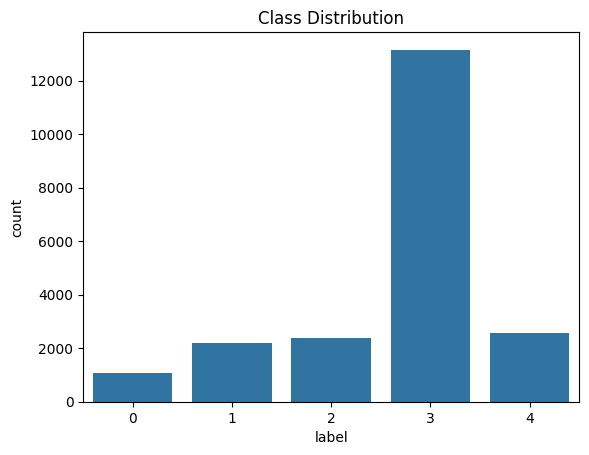

In [ ]:
# Define dataset paths
dataset_path = "/content/drive/MyDrive/cassava_dataset"
image_folder = os.path.join(dataset_path, "train_images")
csv_file = os.path.join(dataset_path, "train.csv")

# Load CSV file
df = pd.read_csv(csv_file)

# Check the first few rows
print(df.head())
print(df['image_id'].head())  # Check the first few filenames

# Check class distribution
sns.countplot(x=df['label'])
plt.title("Class Distribution")
plt.show()



In [ ]:
image_folder = "/content/drive/MyDrive/cassava_dataset/train_images"

if os.path.exists(image_folder):
    print("Image folder exists")
    print("Sample images in directory:", os.listdir(image_folder)[:10])  # Show first 10 images
else:
    print("Image folder does NOT exist! Check your Google Drive path.")

print(os.listdir(image_folder)[:10])  # Show the first 10 image names



Image folder exists
Sample images in directory: ['805835204.jpg', '808870213.jpg', '807190211.jpg', '80998969.jpg', '807555228.jpg', '806670613.jpg', '808606006.jpg', '804903970.jpg', '809489252.jpg', '807063038.jpg']
['805835204.jpg', '808870213.jpg', '807190211.jpg', '80998969.jpg', '807555228.jpg', '806670613.jpg', '808606006.jpg', '804903970.jpg', '809489252.jpg', '807063038.jpg']


In [ ]:
# Define class names mapping
label_to_class = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}

# Display the label-to-class mapping
print("Label to Class Mapping:")
for label, class_name in label_to_class.items():
    print(f"{label}: {class_name}")

Label to Class Mapping:
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy


In [ ]:
# Define paths
csv_path = "/content/drive/MyDrive/cassava_dataset/train.csv"
image_folder = "/content/drive/MyDrive/cassava_dataset/train_images"

# Load train.csv
df = pd.read_csv(csv_path)

# Get lists of image names
csv_images = set(df['image_id'])  # Images listed in CSV
folder_images = set(os.listdir(image_folder))  # Images in train_images folder

# Identify missing and extra images
missing_images = csv_images - folder_images  # In CSV but not in folder
extra_images = folder_images - csv_images  # In folder but not in CSV

# Print results
print(f"Total images in CSV: {len(csv_images)}")
print(f"Total images in folder: {len(folder_images)}")
print(f"Missing images (in CSV but not in folder): {len(missing_images)}")
print(f"Extra images (in folder but not in CSV): {len(extra_images)}")

Total images in CSV: 21397
Total images in folder: 17938
Missing images (in CSV but not in folder): 3459
Extra images (in folder but not in CSV): 0


In [ ]:
# Remove rows in df where images are missing
df = df[~df['image_id'].isin(missing_images)]

# Save cleaned CSV (optional, for future use)
cleaned_csv_path = "/content/drive/MyDrive/cassava_dataset/train_cleaned.csv"
df.to_csv(cleaned_csv_path, index=False)

print(f"Updated dataset size: {len(df)}")


Updated dataset size: 17938


In [ ]:
for img in extra_images:
    img_path = os.path.join(image_folder, img)
    os.remove(img_path)  # Delete extra image

print("Extra images removed successfully!")


Extra images removed successfully!


In [ ]:

# Define constants
IMG_SIZE = 128
BATCH_SIZE = 16

# Define paths
dataset_path = "/content/drive/MyDrive/cassava_dataset"
csv_path = os.path.join(dataset_path, "train.csv")
image_folder = os.path.join(dataset_path, "train_images")

# Load dataset
df = pd.read_csv(csv_path)

# Get actual image filenames from the folder
available_images = set(os.listdir(image_folder))

# Remove rows where images are missing
df = df[df['image_id'].isin(available_images)].reset_index(drop=True)

# Print dataset stats
print(f"Total images in CSV (after cleaning): {len(df)}")
print(f"Total images available in folder: {len(available_images)}")

# Function to preprocess images
def preprocess_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise Exception("Corrupt Image")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # Resize to 224x224
        img = img / 255.0  # Normalize pixel values to [0,1]
        return img
    except:
        print(f"Warning: Could not read image {img_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Return blank image

# Split dataset into train, validation, test
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)






Total images in CSV (after cleaning): 17938
Total images available in folder: 17938


In [ ]:
# Define Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=30,       # Random rotation (0-30 degrees)
    width_shift_range=0.2,   # Horizontal shift (up to 20% of width)
    height_shift_range=0.2,  # Vertical shift (up to 20% of height)
    shear_range=0.2,         # Shearing transformation (distorts shape)
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill missing pixels after transformation
)

#Validation & Test Preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation & test

# Convert 'label' column to string type
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

# Create Data Generators
#train generator(with augumentation)
train_generator = train_datagen.flow_from_dataframe(
    df_train, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse"
)

#Validation Generator-Only rescales images (no augmentation)
val_generator = val_datagen.flow_from_dataframe(
    df_val, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse"
)

#Test Generator (For Final Evaluation)
test_generator = val_datagen.flow_from_dataframe(
    df_test, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse",
    shuffle=False  # No need to shuffle test data
)

# Print dataset sizes
print(f"Train size: {len(df_train)}, Validation size: {len(df_val)}, Test size: {len(df_test)}")
print(" Data preprocessing & augmentation completed successfully!")


Found 12556 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.
Train size: 12556, Validation size: 2691, Test size: 2691
 Data preprocessing & augmentation completed successfully!


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os

# Enable mixed precision for faster training (requires compatible GPU)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Define input shape
IMG_SIZE = 128  # Reduced image size for faster processing
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = 5  # Adjust according to your dataset
BATCH_SIZE = 16  # Reduced batch size for faster training

# Custom CNN Model (Simplified)
def build_custom_cnn(input_shape):
    cnn_model = Sequential([
        Conv2D(32, (3,3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5)
    ])
    return cnn_model

# MobileNetV2 Model (Frozen)
def build_mobilenet(input_shape):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the entire base model initially
    return base_model

# Create models
cnn_model = build_custom_cnn(input_shape)
mobilenet_model = build_mobilenet(input_shape)

# Merge CNN and MobileNetV2 Outputs
single_input = Input(shape=input_shape)
cnn_output = cnn_model(single_input)
mobilenet_output = GlobalAveragePooling2D()(mobilenet_model(single_input))
merged = Concatenate()([cnn_output, mobilenet_output])
final_output = Dense(256, activation='relu')(merged)
final_output = Dropout(0.5)(final_output)
final_output = Dense(num_classes, activation='softmax')(final_output)

# Define final hybrid model
hybrid_model = Model(inputs=single_input, outputs=final_output)

# Compile model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary
hybrid_model.summary()

# Define callbacks
callbacks = [
    ModelCheckpoint("best_hybrid_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]






/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_128      │ (None, 4, 4, 1280)     │      2,257,984 │ input_layer_2[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128)            │      8,408,512 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ mobilenetv2_1.00_128[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1408)           │              0 │ sequential[0][0],      │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        360,704 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 5)              │          1,285 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,028,485 (42.07 MB)

 Trainable params: 8,770,309 (33.46 MB)

 Non-trainable params: 2,258,176 (8.61 MB)

In [ ]:
# Train the model
history = hybrid_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.5516 - loss: 1.5116

785/785 ━━━━━━━━━━━━━━━━━━━━ 534s 650ms/step - accuracy: 0.5517 - loss: 1.5112 - val_accuracy: 0.6585 - val_loss: 0.9706 - learning_rate: 1.0000e-04
Epoch 2/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6574 - loss: 0.9798

785/785 ━━━━━━━━━━━━━━━━━━━━ 187s 192ms/step - accuracy: 0.6574 - loss: 0.9798 - val_accuracy: 0.6696 - val_loss: 0.9380 - learning_rate: 1.0000e-04
Epoch 3/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6630 - loss: 0.9428

785/785 ━━━━━━━━━━━━━━━━━━━━ 156s 198ms/step - accuracy: 0.6630 - loss: 0.9428 - val_accuracy: 0.6793 - val_loss: 0.9270 - learning_rate: 1.0000e-04
Epoch 4/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6675 - loss: 0.9389

785/785 ━━━━━━━━━━━━━━━━━━━━ 207s 205ms/step - accuracy: 0.6675 - loss: 0.9389 - val_accuracy: 0.6823 - val_loss: 0.9123 - learning_rate: 1.0000e-04
Epoch 5/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 190s 189ms/step - accuracy: 0.6807 - loss: 0.8847 - val_accuracy: 0.6630 - val_loss: 0.9276 - learning_rate: 1.0000e-04
Epoch 6/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6786 - loss: 0.8892

785/785 ━━━━━━━━━━━━━━━━━━━━ 200s 187ms/step - accuracy: 0.6787 - loss: 0.8892 - val_accuracy: 0.6722 - val_loss: 0.8998 - learning_rate: 1.0000e-04
Epoch 7/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6848 - loss: 0.8754

785/785 ━━━━━━━━━━━━━━━━━━━━ 206s 192ms/step - accuracy: 0.6848 - loss: 0.8754 - val_accuracy: 0.6771 - val_loss: 0.8930 - learning_rate: 1.0000e-04
Epoch 8/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 147s 187ms/step - accuracy: 0.6841 - loss: 0.8772 - val_accuracy: 0.6719 - val_loss: 0.9000 - learning_rate: 1.0000e-04
Epoch 9/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 205s 191ms/step - accuracy: 0.6992 - loss: 0.8442 - val_accuracy: 0.6667 - val_loss: 0.9217 - learning_rate: 1.0000e-04
Epoch 10/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6967 - loss: 0.8362
Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
785/785 ━━━━━━━━━━━━━━━━━━━━ 198s 185ms/step - accuracy: 0.6967 - loss: 0.8363 - val_accuracy: 0.6637 - val_loss: 0.9168 - learning_rate: 1.0000e-04
Epoch 11/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 208s 193ms/step - accuracy: 0.7010 - loss: 0.8406 - val_accuracy: 0.6748 - val_loss: 0.8950 - learning_rate: 2.0000e-05
Epoch 12/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 197s 186ms/st

In [ ]:
# Evaluate the hybrid model on test set
test_loss, test_acc = hybrid_model.evaluate(test_generator) # Use test_generator instead of test_dataset
print(f"Test Accuracy: {test_acc * 100:.2f}%")



169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.6652 - loss: 0.9200
Test Accuracy: 67.15%


In [ ]:
# Save final model
hybrid_model.save("cassava_hybrid_cnn_mobilenet.h5")
print("Hybrid Model saved successfully!")

Hybrid Model saved successfully!


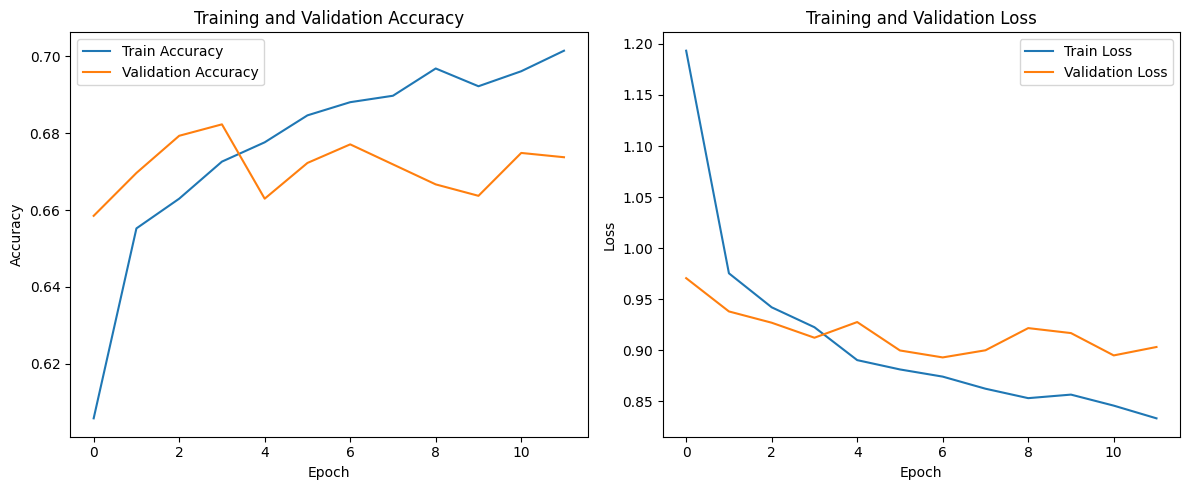

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.6652 - loss: 0.9200
Test Loss: 0.8947
Test Accuracy: 67.15%
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step
Precision: 0.6773
Recall: 0.6715
F1-Score: 0.6640

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.23      0.33       138
           1       0.50      0.42      0.45       275
           2       0.45      0.26      0.33       299
           3       0.82      0.85      0.83      1654
           4       0.35      0.56      0.43       325

    accuracy                           0.67      2691
   macro avg       0.54      0.46      0.48      2691
weighted avg       0.68      0.67      0.66      2691



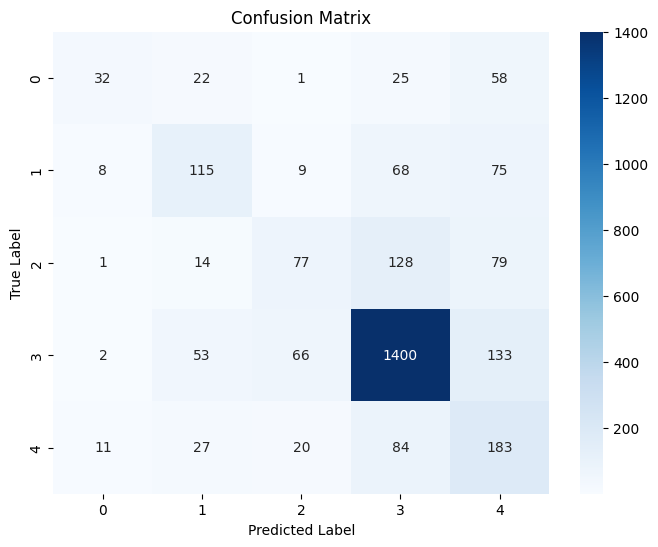

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Evaluate the model on the test set
test_loss, test_accuracy = hybrid_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Get predictions from the test set
y_pred = hybrid_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels
y_true = test_generator.labels

# Compute precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from google.colab import files
files.download("cassava_hybrid_cnn_mobilenet.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install ipywidgets
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.0 MB/s eta 0:00:00


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image  # Import the Image class from PIL
import cv2
import numpy as np

def preprocess_image(image):
    # Resize and normalize the image
    img = cv2.resize(image, (128, 128))  # Resize to match model input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Define class names
class_names = ["Cassava Bacterial Blight (CBB)", "Cassava Brown Streak Disease (CBSD)",
               "Cassava Green Mottle (CGM)", "Cassava Mosaic Disease (CMD)", "Healthy"]

# Create text box for entering image path
path_text = widgets.Text(
    placeholder='Enter the path to the image',
    description='Image Path:',
    disabled=False
)

# Create button for triggering prediction
predict_button = widgets.Button(
    description='Predict',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to predict',
    icon='check'  # (FontAwesome names without the `fa-` prefix)
)

# Create output widget to display results
output = widgets.Output()

# Function to handle prediction
def on_predict_button_clicked(b):
    if path_text.value:
        # Clear previous output
        output.clear_output()

        # Get the image path
        image_path = path_text.value

        # Display the uploaded image
        with output:
            try:
                image = Image.open(image_path)
                display(image)
            except Exception as e:
                print(f"Error loading image: {e}")
                return

        # Convert image to OpenCV format
        image = np.asarray(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

        # Preprocess the image
        img = preprocess_image(image)

        # Make prediction
        prediction = hybrid_model.predict(img)
        predicted_class = class_names[np.argmax(prediction)]

        # Display the prediction
        with output:
            print(f"Prediction: {predicted_class}")

# Attach the function to the button
predict_button.on_click(on_predict_button_clicked)

# Display the widgets
display(path_text)
display(predict_button)
display(output)

Text(value='', description='Image Path:', placeholder='Enter the path to the image')

Button(description='Predict', icon='check', style=ButtonStyle(), tooltip='Click to predict')

Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


In [ ]:
/content/drive/MyDrive/cassava_dataset/train_images/1593718763.jpg

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define constants
IMG_SIZE = 128
BATCH_SIZE = 16
NUM_CLASSES = 5

# Load EfficientNetB0 model
def build_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation="softmax")(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Build the EfficientNet model
efficientnet_model = build_efficientnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

# Compile the model
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary
efficientnet_model.summary()

# Define callbacks
callbacks = [
    ModelCheckpoint("best_efficientnet_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# Train the EfficientNet model
history_efficientnet = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

# Evaluate the EfficientNet model on the test set
test_loss_efficientnet, test_acc_efficientnet = efficientnet_model.evaluate(test_generator)
print(f"EfficientNet Test Accuracy: {test_acc_efficientnet * 100:.2f}%")

# Save the EfficientNet model
efficientnet_model.save("efficientnet_model.h5")
print("EfficientNet Model saved successfully!")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 128, 128, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ cast_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce    

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6133 - loss: 1.2200

785/785 ━━━━━━━━━━━━━━━━━━━━ 207s 231ms/step - accuracy: 0.6133 - loss: 1.2200 - val_accuracy: 0.6150 - val_loss: 1.1841 - learning_rate: 1.0000e-04
Epoch 2/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6160 - loss: 1.1995

785/785 ━━━━━━━━━━━━━━━━━━━━ 156s 189ms/step - accuracy: 0.6160 - loss: 1.1995 - val_accuracy: 0.6150 - val_loss: 1.1833 - learning_rate: 1.0000e-04
Epoch 3/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6113 - loss: 1.2104

785/785 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.6113 - loss: 1.2104 - val_accuracy: 0.6150 - val_loss: 1.1825 - learning_rate: 1.0000e-04
Epoch 4/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 201s 191ms/step - accuracy: 0.6183 - loss: 1.2042 - val_accuracy: 0.6150 - val_loss: 1.1915 - learning_rate: 1.0000e-04
Epoch 5/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6159 - loss: 1.1983

785/785 ━━━━━━━━━━━━━━━━━━━━ 202s 190ms/step - accuracy: 0.6159 - loss: 1.1983 - val_accuracy: 0.6150 - val_loss: 1.1818 - learning_rate: 1.0000e-04
Epoch 6/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6172 - loss: 1.2002

785/785 ━━━━━━━━━━━━━━━━━━━━ 204s 193ms/step - accuracy: 0.6172 - loss: 1.2002 - val_accuracy: 0.6150 - val_loss: 1.1803 - learning_rate: 1.0000e-04
Epoch 7/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 147s 188ms/step - accuracy: 0.6130 - loss: 1.1957 - val_accuracy: 0.6150 - val_loss: 1.1882 - learning_rate: 1.0000e-04
Epoch 8/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6125 - loss: 1.2008

785/785 ━━━━━━━━━━━━━━━━━━━━ 205s 192ms/step - accuracy: 0.6125 - loss: 1.2008 - val_accuracy: 0.6150 - val_loss: 1.1799 - learning_rate: 1.0000e-04
Epoch 9/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 199s 189ms/step - accuracy: 0.6218 - loss: 1.1865 - val_accuracy: 0.6150 - val_loss: 1.1818 - learning_rate: 1.0000e-04
Epoch 10/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6133 - loss: 1.2060

785/785 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.6133 - loss: 1.2060 - val_accuracy: 0.6150 - val_loss: 1.1796 - learning_rate: 1.0000e-04
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.6201 - loss: 1.1716


EfficientNet Test Accuracy: 61.46%
EfficientNet Model saved successfully!


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define save path in Google Drive
save_path = '/content/drive/MyDrive/efficientnet_model.h5'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
efficientnet_model.save(save_path)
print(f"Model saved to Google Drive at: {save_path}")

In [ ]:
from google.colab import drive
import tensorflow as tf

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Path to your saved model
model_path = '/content/drive/MyDrive/efficientnet_model.h5'

# Load the model
try:
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully from Google Drive!")
except Exception as e:
    print(f"Error loading model: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model loaded successfully from Google Drive!


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image  # Import the Image class from PIL
import cv2
import numpy as np

def preprocess_image(image):
    # Resize and normalize the image
    img = cv2.resize(image, (128, 128))  # Resize to match model input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Define class names
class_names = ["Cassava Bacterial Blight (CBB)", "Cassava Brown Streak Disease (CBSD)",
               "Cassava Green Mottle (CGM)", "Cassava Mosaic Disease (CMD)", "Healthy"]

# Create text box for entering image path
path_text = widgets.Text(
    placeholder='Enter the path to the image',
    description='Image Path:',
    disabled=False
)

# Create button for triggering prediction
predict_button = widgets.Button(
    description='Predict',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to predict',
    icon='check'  # (FontAwesome names without the `fa-` prefix)
)

# Create output widget to display results
output = widgets.Output()

# Function to handle prediction
def on_predict_button_clicked(b):
    if path_text.value:
        # Clear previous output
        output.clear_output()

        # Get the image path
        image_path = path_text.value

        # Display the uploaded image
        with output:
            try:
                image = Image.open(image_path)
                display(image)
            except Exception as e:
                print(f"Error loading image: {e}")
                return

        # Convert image to OpenCV format
        image = np.asarray(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

        # Preprocess the image
        img = preprocess_image(image)

        # Make prediction
        prediction = model.predict(img)
        predicted_class = class_names[np.argmax(prediction)]

        # Display the prediction
        with output:
            print(f"Prediction: {predicted_class}")

# Attach the function to the button
predict_button.on_click(on_predict_button_clicked)

# Display the widgets
display(path_text)
display(predict_button)
display(output)

Text(value='', description='Image Path:', placeholder='Enter the path to the image')

Button(description='Predict', icon='check', style=ButtonStyle(), tooltip='Click to predict')

Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step
Hybrid CNN + MobileNet Classification Report:
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.59      0.23      0.33       138
Cassava Brown Streak Disease (CBSD)       0.50      0.42      0.45       275
         Cassava Green Mottle (CGM)       0.45      0.26      0.33       299
       Cassava Mosaic Disease (CMD)       0.82      0.85      0.83      1654
                            Healthy       0.35      0.56      0.43       325

                           accuracy                           0.67      2691
                          macro avg       0.54      0.46      0.48      2691
                       weighted avg       0.68      0.67      0.66      2691

EfficientNet Classification Report:
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.00      0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


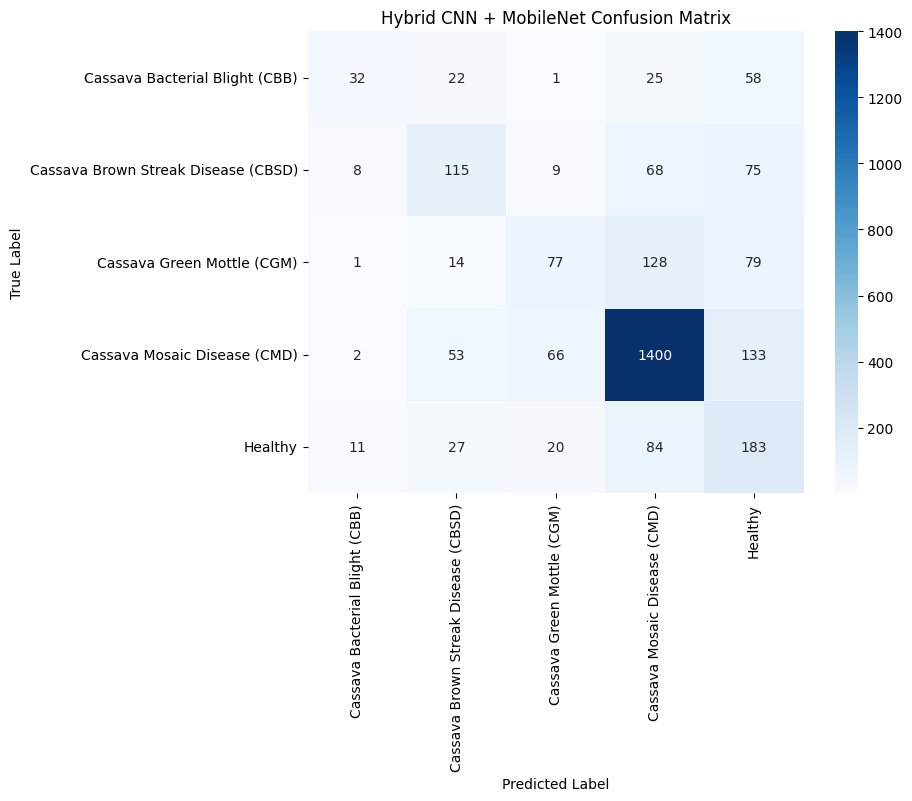

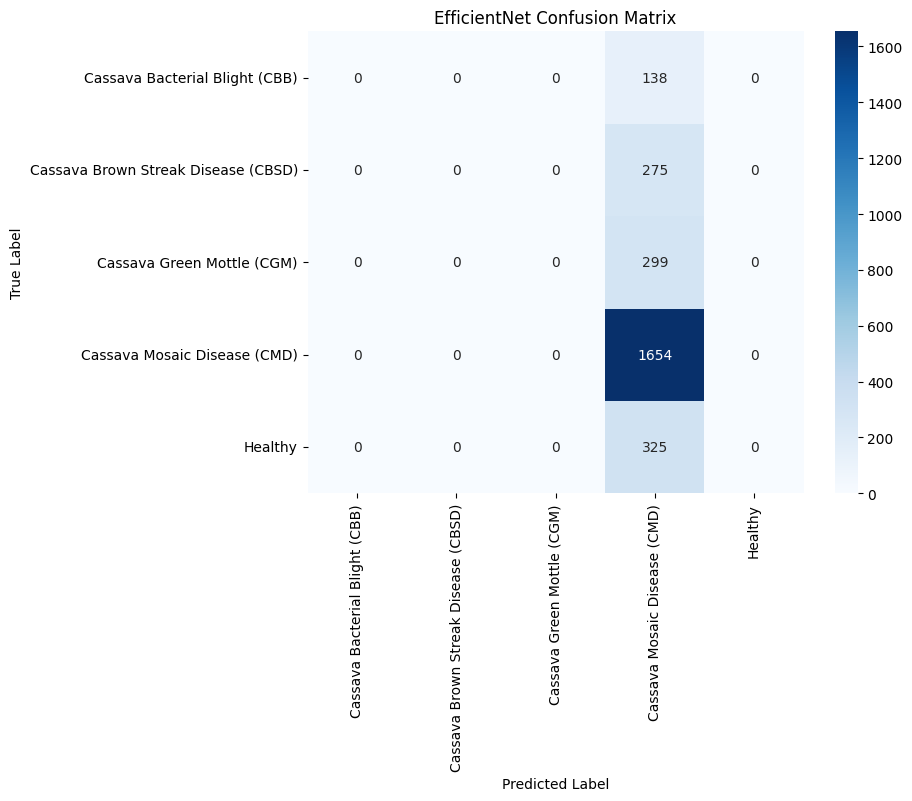

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions from the test set for both models
y_pred_hybrid = hybrid_model.predict(test_generator)
y_pred_hybrid = np.argmax(y_pred_hybrid, axis=1)

y_pred_efficientnet = efficientnet_model.predict(test_generator)
y_pred_efficientnet = np.argmax(y_pred_efficientnet, axis=1)

# Get true labels
y_true = test_generator.labels

# Classification Report for Hybrid Model
print("Hybrid CNN + MobileNet Classification Report:")
print(classification_report(y_true, y_pred_hybrid, target_names=class_names))

# Classification Report for EfficientNet
print("EfficientNet Classification Report:")
print(classification_report(y_true, y_pred_efficientnet, target_names=class_names))

# Confusion Matrix for Hybrid Model
cm_hybrid = confusion_matrix(y_true, y_pred_hybrid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Hybrid CNN + MobileNet Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Confusion Matrix for EfficientNet
cm_efficientnet = confusion_matrix(y_true, y_pred_efficientnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_efficientnet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('EfficientNet Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()






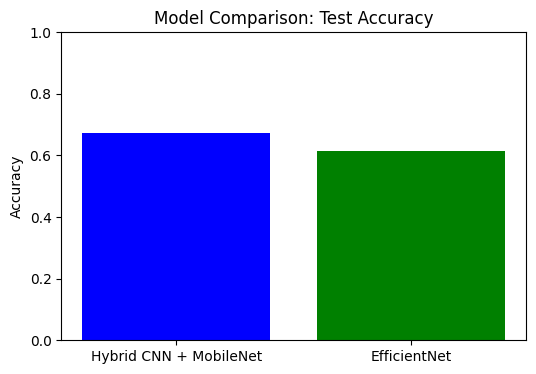


Comparison of Precision, Recall, and F1-Score:
                    Model  Precision    Recall  F1-Score
0  Hybrid CNN + MobileNet   0.677268  0.671498  0.663972
1            EfficientNet   0.377784  0.614641  0.467948


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Compare Accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Hybrid CNN + MobileNet', 'EfficientNet'], [test_acc, test_acc_efficientnet], color=['blue', 'green'])  # Use 'test_acc' instead of 'test_acc_hybrid'
plt.title('Model Comparison: Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Compare Precision, Recall, and F1-Score
precision_hybrid = precision_score(y_true, y_pred_hybrid, average='weighted')
recall_hybrid = recall_score(y_true, y_pred_hybrid, average='weighted')
f1_hybrid = f1_score(y_true, y_pred_hybrid, average='weighted')

precision_efficientnet = precision_score(y_true, y_pred_efficientnet, average='weighted')
recall_efficientnet = recall_score(y_true, y_pred_efficientnet, average='weighted')
f1_efficientnet = f1_score(y_true, y_pred_efficientnet, average='weighted')

metrics_df = pd.DataFrame({
    'Model': ['Hybrid CNN + MobileNet', 'EfficientNet'],
    'Precision': [precision_hybrid, precision_efficientnet],
    'Recall': [recall_hybrid, recall_efficientnet],
    'F1-Score': [f1_hybrid, f1_efficientnet]
})

print("\nComparison of Precision, Recall, and F1-Score:")
print(metrics_df)